In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import json
import glob
import time

In [2]:
data = {}
for path in glob.glob(r"../../Data/t_taxi/raw_*.csv"):
    data[path.split('\\')[-1].split('.')[0]] = pd.read_csv(path)
data.keys()

dict_keys(['raw_dep_h0', 'raw_dep_h120', 'raw_dep_h180', 'raw_dep_h30'])

In [3]:
with open("../../Data/t_taxi/csv_docs.json", "r") as f:
    docs = json.load(f)

In [47]:
h = 30
df = data['raw_dep_h{}'.format(h)].copy()
#df['center_crossing'][(df['center_crossing']=='-')|(df['trwy']!='36L')] = np.nan
df.loc[(df['center_crossing']=='-')|(df['trwy']!='36L'), 'center_crossing'] = np.nan
df['trwy_ext'] = df['trwy'] + ("_" + df['center_crossing']).fillna('')
df.sort_values('t_predict')

X_cols_circ = []
X_cols_num = []
X_cols_cat = []
astype_dict = {}
for col in df.columns:
    if "dtype" == col:
        continue
    if 'circular' in docs[col]['type']:
        X_cols_circ.append(col)
        docs[col]['type'].append("cat") # just to be sure
    if "num" in docs[col]['type']:
        X_cols_num.append(col)
        astype_dict[col] = np.float64
    if "cat" in docs[col]['type']:
        X_cols_cat.append(col)
        astype_dict[col] = "category"
        
X_cols = X_cols_cat + X_cols_num

In [48]:
df = df[['t_taxi_end', 'final_trwy', 't_spent']]
df = df[df['final_trwy']!='06']
df['final_trwy'] = df['final_trwy'].replace({"22": "04/22", "04": "04/22"})
df = df.reset_index()

df['t_spent'] = df['t_spent'].apply(literal_eval)

from ast import literal_eval
df = df.join(pd.json_normalize(df['t_spent']).fillna(0))

# # drop Pollutants
# df.drop(columns=['t_spent'], inplace=True)

## Method 1

In [51]:
t0 = time.time()
a = []
for (i, row) in df.iterrows():
    a.append(row[row['final_trwy'] + '_queue'])
    if i % 10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000


In [76]:
data = pd.concat([df[['t_taxi_end', 'final_trwy']], pd.Series(a, index= df.index).rename("queue")], axis=1)
data['month'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.month
data['year'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.year
data['dayofyear'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.dayofyear

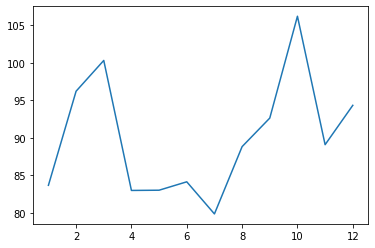

In [80]:
import matplotlib.pyplot as plt
plot_data = data[data['year']==2019][['queue', 'month']].groupby('month').mean()
plt.plot(plot_data.index, plot_data['queue'])
plt.show()

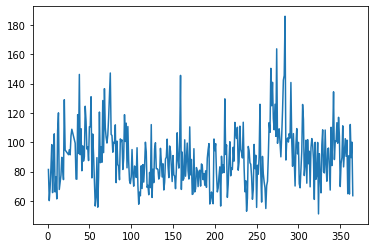

In [81]:
import matplotlib.pyplot as plt
plot_data = data[data['year']==2019][['queue', 'dayofyear']].groupby('dayofyear').mean()
plt.plot(plot_data.index, plot_data['queue'])
plt.show()

In [12]:
import re
r = re.compile(r".*_queue")
list(filter(r.match, list(df.columns)))

['09_queue',
 '36C_queue',
 '18L_queue',
 '24_queue',
 '36L_queue',
 '18C_queue',
 '27_queue',
 '04/22_queue']

## Alternative Method:

In [82]:
def f(x):
    try:
        return x['t_spent'][x['final_trwy'] + '_queue']
    except KeyError:
        return 0

df['queue'] = df.apply(f, axis=1)

data = df[['t_taxi_end', 'queue']]
data['month'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.month
data['year'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.year
data['dayofyear'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.dayofyear

<ipython-input-82-2dff61eecd8f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.month
<ipython-input-82-2dff61eecd8f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.to_datetime(df['t_taxi_end']).dt.tz_convert("Europe/Amsterdam").dt.year
<ipython-input-82-2dff61eecd8f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

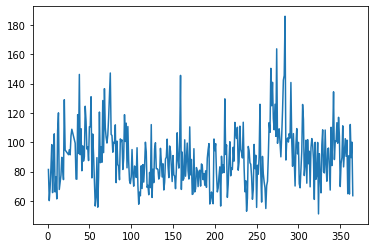

In [83]:
import matplotlib.pyplot as plt
plot_data = data[data['year']==2019][['queue', 'dayofyear']].groupby('dayofyear').mean()
plt.plot(plot_data.index, plot_data['queue'])
plt.show()